In [1]:
import pandas as pd
from data_process.preprocessing import discretization, get_nodes_type, code_categories
from block_learning.train_bn import structure_learning, parameter_learning
from block_learning.partial_bn_train import connect_partial_bn, hierarchical_train, direct_connect, direct_train
from sklearn.utils import resample
import seaborn as sns
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from block_learning.save_bn import save_structure, save_params
from block_learning.read_bn import read_structure, read_params
from block_learning.sampling import generate_synthetics, get_probability
from libpgm.hybayesiannetwork import HyBayesianNetwork
from visualization.visualization import draw_BN, draw_comparative_hist
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve

## Есть анкеты клиентов и факт открытия депозита (поле deposit)

In [2]:
data = pd.read_csv('data/bank.csv')
data.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes
5,42,management,single,tertiary,no,0,yes,yes,unknown,5,may,562,2,-1,0,unknown,yes
6,56,management,married,tertiary,no,830,yes,yes,unknown,6,may,1201,1,-1,0,unknown,yes
7,60,retired,divorced,secondary,no,545,yes,no,unknown,6,may,1030,1,-1,0,unknown,yes
8,37,technician,married,secondary,no,1,yes,no,unknown,6,may,608,1,-1,0,unknown,yes
9,28,services,single,secondary,no,5090,yes,no,unknown,6,may,1297,3,-1,0,unknown,yes


In [3]:
data.dropna(inplace=True)
data.reset_index(inplace=True, drop=True)

In [4]:
data = data[['age', 'balance', 'duration', 'deposit']]

In [5]:
data = code_categories(data, ['deposit'])

In [6]:
data.head(10)

,age,balance,duration,deposit
0,59,2343,1042,1
1,56,45,1467,1
2,41,1270,1389,1
3,55,2476,579,1
4,54,184,673,1
5,42,0,562,1
6,56,830,1201,1
7,60,545,1030,1
8,37,1,608,1
9,28,5090,1297,1


In [7]:
data.shape

(11162, 4)

In [8]:
Y_real = data['deposit'].values
X_real = data.drop(columns=['deposit']).values

In [9]:
model = LogisticRegression(max_iter=1000)


In [10]:
cv = ShuffleSplit(n_splits=10, test_size=0.4, random_state=0)
print(cross_val_score(model, X_real, Y_real, cv=cv, scoring='roc_auc'))
print('Средний score на тестовой выборке', np.mean(cross_val_score(model, X_real,Y_real, cv=cv, scoring='roc_auc')))

[0.80507726 0.8076115  0.76828159 0.81270851 0.81179514 0.80542005
 0.77821648 0.76326357 0.7980895  0.8049405 ]
Средний score на тестовой выборке 0.7955404095921736


## Но что если персональные данные мы не можем использовать для построения модели? Можем анонимизировать!

In [11]:
data_new = data.sample(100)

In [12]:
node_type = get_nodes_type(data_new)
node_type

{'age': 'disc', 'balance': 'disc', 'duration': 'disc', 'deposit': 'disc'}

In [13]:
node_type['balance'] = 'cont'

In [14]:
data_discrete = discretization(data_new, 'equal_frequency', ['balance'])

In [15]:
bn = structure_learning(data_discrete, 'K2', node_type)

  0%|          | 5/1000000 [00:00<6:49:59, 40.65it/s]


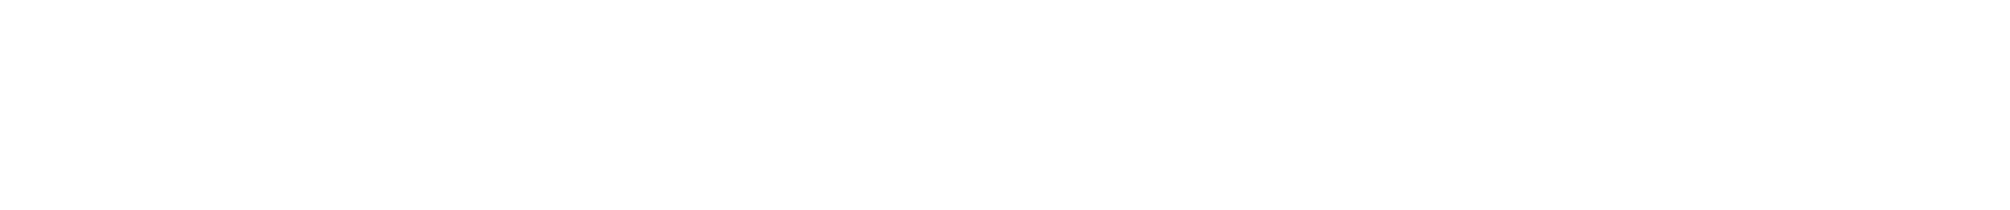

In [16]:
draw_BN(bn, node_type, 'bank_bn')

In [17]:
param = parameter_learning(data_new, node_type, bn)

In [18]:
save_structure(bn, 'bank_bn')
skel1 = read_structure('bank_bn')
save_params(param, 'bank_bn')
params1 = read_params('bank_bn')
hybn1 = HyBayesianNetwork(skel1, params1)

In [19]:
sample = generate_synthetics(hybn1)

In [20]:
sample = sample.loc[sample['balance'] >= 0]
sample.iloc[:,:] = sample.iloc[:,:].astype('int')
sample.shape

(2823, 4)

In [21]:
sample.head(10)

,deposit,age,duration,balance
0,0,60,104,125
1,0,40,350,291
2,1,31,655,2120
3,0,36,118,219
4,1,25,597,253
5,0,56,1504,433
6,0,31,1389,425
7,0,43,34,391
8,1,32,1249,0
9,0,36,350,291


C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


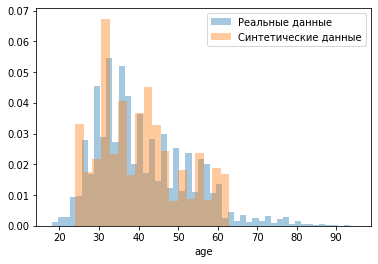

In [22]:
sns.distplot(data['age'], label='Реальные данные', norm_hist=True, kde=False)
sns.distplot(sample['age'], label='Синтетические данные', norm_hist=True, kde=False)
plt.legend()

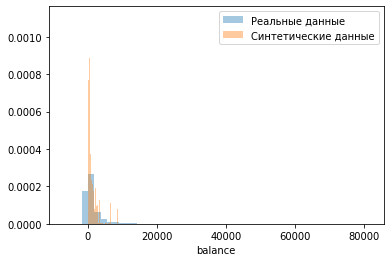

In [23]:
sns.distplot(data['balance'], label='Реальные данные', norm_hist=True, kde=False)
sns.distplot(sample['balance'], label='Синтетические данные', norm_hist=True, kde=False)
plt.legend()

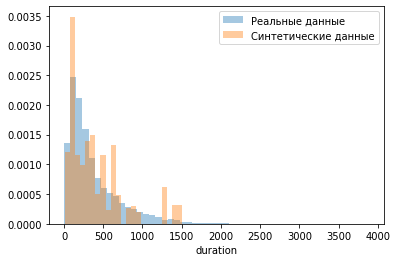

In [24]:
sns.distplot(data['duration'], label='Реальные данные', norm_hist=True, kde=False)
sns.distplot(sample['duration'], label='Синтетические данные', norm_hist=True, kde=False)
plt.legend()

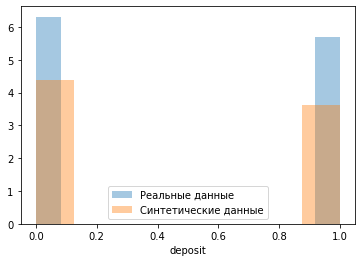

In [25]:
sns.distplot(data['deposit'], label='Реальные данные', norm_hist=True, kde=False)
sns.distplot(sample['deposit'], label='Синтетические данные', norm_hist=True, kde=False)
plt.legend()

In [26]:
Y = sample['deposit'].values
X = sample.drop(columns=['deposit']).values

In [27]:
model_synth = LogisticRegression(max_iter=1000)

In [28]:
cv = ShuffleSplit(n_splits=10, test_size=0.4, random_state=0)
print(cross_val_score(model_synth, X, Y, cv=cv, scoring='roc_auc'))
print('Средний score на тестовой выборке', np.mean(cross_val_score(model_synth, X, Y, cv=cv, scoring='roc_auc')))

[0.78784556 0.78455233 0.80935656 0.78525523 0.77429989 0.80723656
 0.79309625 0.80261335 0.77899048 0.79880522]
Средний score на тестовой выборке 0.7922051421855351


## А теперь проверим на реальных данных

In [29]:
model_synth = LogisticRegression(max_iter=1000)
model_synth.fit(X,Y)

LogisticRegression(max_iter=1000)

In [30]:
pred_scr = model_synth.predict_proba(X_real)[:, 1]
fpr, tpr, thresholds = roc_curve(Y_real, pred_scr)
roc_auc = metrics.auc(fpr, tpr)
roc_auc

0.6065773403686148